### 06/25/23
### Joshua Edelstein
# Pneumonia Analysis
## Overview


## Business Understanding 

<div>
<img src="images/xray.jpg", width = 800, height = 400/>
</div>

Photo by <a href="https://unsplash.com/@nci?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">National Cancer Institute</a> on <a href="https://unsplash.com/s/photos/x-ray?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  

## Inspect and Prepare Data

### Look at some Images



In [228]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras import optimizers, regularizers, initializers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
plt.rcParams['figure.figsize']=(20,20)
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os

from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import tensorflow as tf
import random

# Set the random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [49]:
# Set the random seed
np.random.seed(42)

#rename the data path
train_data_dir = 'data/train'
test_data_dir = 'data/test'
val_data_dir ='data/val'

# Get all the data in the directory data/train (5216 images), and reshape them
print('Train Images:')
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=5216)

print('Test Images:')
# Get all the data in the directory data/validation (624 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(64, 64), batch_size=624)
print('Val Images:')
# Get all the data in the directory data/train (16 images), and reshape them
val_generator = ImageDataGenerator().flow_from_directory(
        val_data_dir, 
        target_size=(64, 64), batch_size=16)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Train Images:
Found 5216 images belonging to 2 classes.
Test Images:
Found 624 images belonging to 2 classes.
Val Images:
Found 16 images belonging to 2 classes.


In [82]:
# Map label values to label names
label_names = ['Normal', 'Pneumonia']
train_labels_updated = np.array([label_names[int(label)] for label in train_labels.flatten()])

# Print the updated labels array
print(train_labels_updated)

['Normal' 'Pneumonia' 'Pneumonia' ... 'Pneumonia' 'Pneumonia' 'Normal']


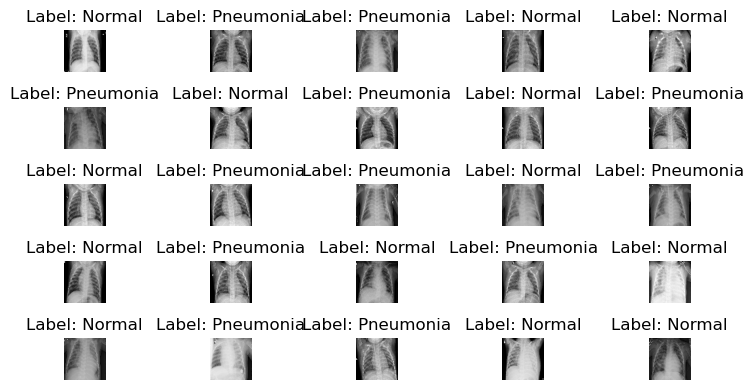

In [229]:
fig, axes = plt.subplots(5, 5, figsize=(8, 4))  # Adjust the figure size as per your preference

for i, ax in enumerate(axes.flat):
    image = array_to_img(train_images[i])
    label = train_labels_updated[i]
    
    ax.imshow(image)
    ax.set_title('Label: ' + str(label))
    ax.axis('off')

plt.tight_layout()
plt.show()


### The Shape of the Data
Now, let's use np.shape() to look at what these numpy arrays look like.

In [5]:
#Use np.shape() to print the shape of the image array and label array
print('Train Images:', np.shape(train_images))
print('Train Labels:',np.shape(train_labels))
print('Test Images:',np.shape(test_images))
print('Test Labels:',np.shape(test_labels))
print('Val Images:',np.shape(val_images))
print('Val Labels:',np.shape(val_labels))

Train Images: (5216, 64, 64, 3)
Train Labels: (5216, 2)
Test Images: (624, 64, 64, 3)
Test Labels: (624, 2)
Val Images: (16, 64, 64, 3)
Val Labels: (16, 2)


In [84]:
dict_class = train_generator.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  # storing class/breed names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'NORMAL_train': 0, 'PNEUMONIA_train': 1}
Class labels: ['NORMAL_train', 'PNEUMONIA_train']


Dataset Characteristics of Train Data Set:
Number of images: 5216
Number of normal images: 1341
Number of pneumonia images: 3875



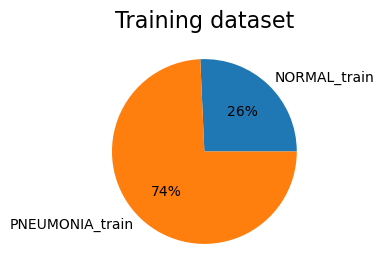

In [85]:
frequency = np.unique(train_generator.classes, return_counts=True)
plt.figure(figsize=(3, 3))
plt.title("Training dataset", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

# Dataset characteristics
print("Dataset Characteristics of Train Data Set:")
print("Number of images:", len(train_generator.classes))
print("Number of normal images:", len([label for label in train_generator.classes if label == 0]))
print("Number of pneumonia images:", len([label for label in train_generator.classes if label == 1]))
print()

Dataset Characteristics of Test Data Set:
Number of images: 624
Number of normal images: 234
Number of pneumonia images: 390



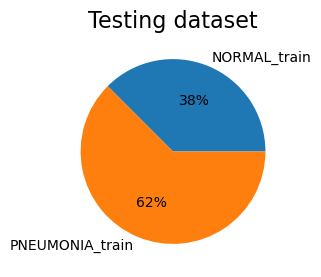

In [86]:
frequency = np.unique(test_generator.classes, return_counts=True)
plt.figure(figsize=(3, 3))
plt.title("Testing dataset", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

print("Dataset Characteristics of Test Data Set:")
print("Number of images:", len(test_generator.classes))
print("Number of normal images:", len([label for label in test_generator.classes if label == 0]))
print("Number of pneumonia images:", len([label for label in test_generator.classes if label == 1]))
print()

Dataset Characteristics of Test Data Set:
Number of images: 16
Number of normal images: 8
Number of pneumonia images: 8



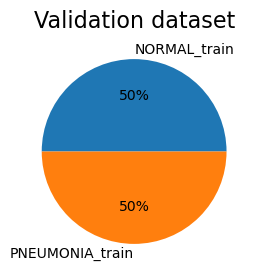

In [87]:
frequency = np.unique(val_generator.classes, return_counts=True)
plt.figure(figsize=(3,3))
plt.title("Validation dataset", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

print("Dataset Characteristics of Test Data Set:")
print("Number of images:", len(val_generator.classes))
print("Number of normal images:", len([label for label in val_generator.classes if label == 0]))
print("Number of pneumonia images:", len([label for label in val_generator.classes if label == 1]))
print()

### `train_images`, `test_images`, and `val_images`

We need to reshape out data to make it usable in neural network. Right now our data is arranged as `(5216, 64, 64, 3)`. The first number represents the number of images we have, for our train set, that number is 5216. The next 3 numbers represent the number of elements in the feature vector for each image. In other words, it's the number of rows when unrowing the 3 (RGB) 64 x 64 matrices.

So we need to transform this so that the data is arranged as (5216, 64x64x3)

In [88]:
# Reshape the train, test and val images 
train_img_unrow = train_images.reshape(-1, 64*64*3)
test_img_unrow = test_images.reshape(-1, 64*64*3)
val_img_unrow = val_images.reshape(-1, 64*64*3)

Verify that the shape of the the newly created `train_img_unrow` is correct.

In [7]:
# Preview the shape of train_img_unrow
np.shape(train_img_unrow)

(5216, 12288)

### `train_labels`,  `test_labels`, and `val_labels`

Earlier, you noticed that `train_labels`, `test_labels` and `val_labels` have shapes of (5216, 2), (624, 2), and (16, 2)

Let's have a closer look.

In [89]:
train_labels

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

Looking at this, it's clear that for each observation (or image), train_labels doesn't simply have an output of 1 or 0, but a pair - either `[0, 1]` or `[1, 0]`

Having this information, we still don't know which pair corresponds with `Normal`(healthy) vs `Pneumonia`. However, we already stored this information using keras.preprocessing_image. Let's pull it up

In [90]:
#use class indices within train_generator to pull up the key for the data
train_generator.class_indices

{'NORMAL_train': 0, 'PNEUMONIA_train': 1}

Index 0 (the first column) represents `Normal`, index 1 represents `Pneumonia`. Let's transpose all the columns so that value 1 represents `Pneumonia`.

In [91]:
#create new datasets that are transposed versions of the label dataset
train_labels_final = train_labels.T[[1]]
test_labels_final = test_labels.T[[1]]
val_labels_final = val_labels.T[[1]]

In [92]:
train_labels_final = train_labels_final.T
test_labels_final = test_labels_final.T
val_labels_final = val_labels_final.T

In [93]:
print(np.shape(train_labels_final))
print(np.shape(test_labels_final))
print(np.shape(val_labels_final))

(5216, 1)
(624, 1)
(16, 1)


Now, we are ready to move on to creating our neural network

## Build a Neural Network

For our models we will set a random seed so that the results are reproducible, additionally we will use a sequential model, where one layer builds of the previous layer. 

In [161]:
# Create the baseline model
baseline_model = Sequential()

### Add layers
Now that we have initialized a network we will add layers to the network, which include the number of layers, as well as the activation function.

The Dense() class indicates that this layer will be fully connected. 

For our `baseline_model` we'll use one hidden layers with 64 unitswith a 'relu' activation function. Also, since this is the first hidden layer, we'll pass in input_shape=(12288,). Since we are dealing with a multiclass problem (classifying the xrays into 2), we'll use a 'softmax' classifier in order to output 2 class probabilities per case

In [162]:
np.random.seed(42)
#add the hidden layer to the NN with 64 units, and an activation of 'relu'
baseline_model.add(Dense(64, activation='relu', input_shape=(12288,)))

#add the output layer with 1 units and an activation of sigmoid
baseline_model.add(Dense(1, activation='sigmoid'))  # Output layer with 2 unit for binary classification

Now, let's move on to compiling our model. We'll use `'SGD'` as our optimizer for our baseline model. For our loss we'll use binary crossentropy since this is a binary classification problem. 

In [163]:
# Compile the model #(optimizers.RMSprop(lr=0.001)) adam, AdamW
baseline_model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])

Before we run our model lets pull up some summary statistics

In [164]:
#pull up summary statistics
baseline_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 64)                786496    
                                                                 
 dense_40 (Dense)            (None, 1)                 65        
                                                                 
Total params: 786,561
Trainable params: 786,561
Non-trainable params: 0
_________________________________________________________________


We see that our model has 786,626 trainable parameters, and this is only our baseline model. 
Now let's move on to actually fitting and running our model.

Before we do that we'll create an early stop function, which stops the model if there is no improvement in the validation set loss. In our case, we need to minimize false positives, which because then we would assume patients don't have pneumonia when they really do. Since our testing set is almost balanced we will monitor accuracy and most likely a higher recall will come along with it. Later on when we get better models, we will look focus closer on recall. We'll allow it to run 5 epochs with no improvement before it stops the model.

We'll start out with only 10 epochs and a batch size of 64. We'll also use our test set to test our model

In [169]:
# Define the callbacks, continue training for 5 epochs before stopping
early_stopping = [EarlyStopping(monitor='val_accuracy', patience=5), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True)]

In [170]:
# Train the model
results_baseline = baseline_model.fit(train_img_unrow, train_labels_final, epochs=10, 
                                      batch_size=64, callbacks=early_stopping,
                                      validation_data=(test_img_unrow, test_labels_final))

Epoch 1/10
82/82 [==============================] - 1s 7ms/step - loss: 0.5741 - accuracy: 0.7429 - val_loss: 0.6764 - val_accuracy: 0.6250
Epoch 2/10
82/82 [==============================] - 1s 7ms/step - loss: 0.5729 - accuracy: 0.7429 - val_loss: 0.6788 - val_accuracy: 0.6250
Epoch 3/10
82/82 [==============================] - 1s 7ms/step - loss: 0.5721 - accuracy: 0.7429 - val_loss: 0.6808 - val_accuracy: 0.6250
Epoch 4/10
82/82 [==============================] - 1s 7ms/step - loss: 0.5715 - accuracy: 0.7429 - val_loss: 0.6827 - val_accuracy: 0.6250
Epoch 5/10
82/82 [==============================] - 1s 7ms/step - loss: 0.5711 - accuracy: 0.7429 - val_loss: 0.6844 - val_accuracy: 0.6250
Epoch 6/10
82/82 [==============================] - 1s 7ms/step - loss: 0.5708 - accuracy: 0.7429 - val_loss: 0.6859 - val_accuracy: 0.6250


Now, let's create a function that takes in our results and plots how they did in terms of accuracy and loss on both the training set as well as the validation set

In [174]:
#name function visualize_training_results
def visualize_training_results(results):
    #set the history
    history = results.history
    
    #create figure for loss
    plt.figure(figsize=(5,5))
    
    # Plot the validation set loss below 100 followed by the training set loss below 1000
    plt.plot([loss for loss in history['val_loss'] if loss < 1000])
    plt.plot([loss for loss in history['loss'] if loss < 1000])
    
    #ad a legend
    plt.legend(['val_loss', 'loss'])
    
    #label the graph and axes
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    #create a figure for accuracy
    plt.figure(figsize=(5,5))
    
    #plot the accuracy for both the validation and training set
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    
    #create a legend
    plt.legend(['val_accuracy', 'accuracy'])
    
    #Label the graph and it's axes
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

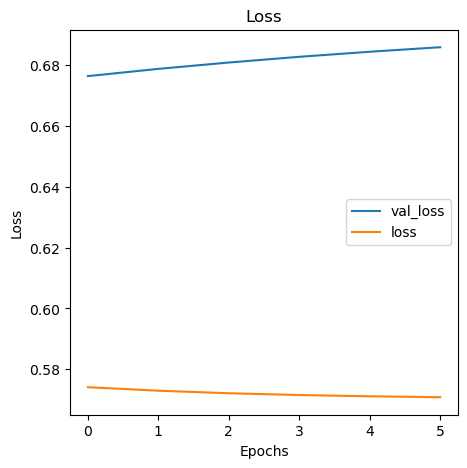

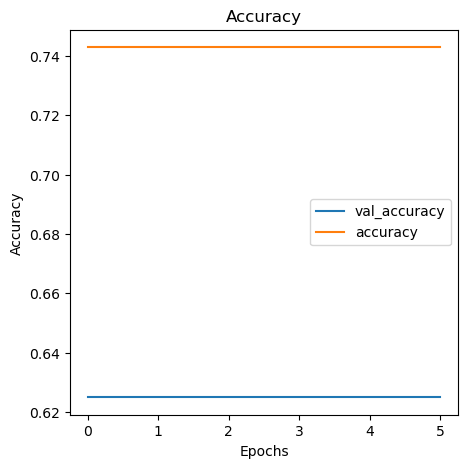

In [175]:
visualize_training_results(results_baseline)

In [227]:
# Assuming `baseline_model` is your trained model
predictions = baseline_model.predict(test_img_unrow)
predicted_labels = np.argmax(predictions, axis=1)

# Generate classification report
classification_rep = classification_report(test_labels_final, predicted_labels)
print(classification_rep)

20/20 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

         0.0       0.38      1.00      0.55       234
         1.0       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



2023-06-27 14:12:22.158590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/Users/joshuaedelstein/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joshuaedelstein/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joshuaedelstein/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-s

Being that the loss and accuracy remained roughly the same for both sets over the course of our model, we can say that this isn't a great model. Our loss for the training set ended up being around .6, while it was around .75 for the validation set. Additionally, our accuracy for the training set remained around 75% while our accuracy for the validation set was only a mere 62.5%, which is on average barely better than random guessing. Our model stopped early as there was no improvement.

## Building a bigger model

Let's create a new model with another hidden layer and tune some other parameters to see how our model improves

In [225]:
tf.random.set_seed(42)

# Create the baseline model
model2 = Sequential()

#add first hidden layer, with 2048 hidden units and activation of relu
model2.add(Dense(64, activation='relu', input_shape=(12288,)))  

#second hidden layer with 1024 units and relu activation
model2.add(Dense(32, activation='relu'))   

# Output layer with 2 units for binary classification
model2.add(Dense(1, activation='sigmoid'))

# Compile the model using adam
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model2.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_95 (Dense)            (None, 64)                786496    
                                                                 
 dense_96 (Dense)            (None, 32)                2080      
                                                                 
 dense_97 (Dense)            (None, 1)                 33        
                                                                 
Total params: 788,609
Trainable params: 788,609
Non-trainable params: 0
_________________________________________________________________


In [226]:
tf.random.set_seed(42)
# Fit the model to the training data, run 20 epochs and use a batch size of 64
results2 = model2.fit(train_img_unrow, train_labels_final, epochs=20, batch_size=64,
                      callbacks=early_stopping,
                      validation_data=(test_img_unrow, test_labels_final))

Epoch 1/20


2023-06-27 14:09:58.211677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - ETA: 0s - loss: 67.8128 - accuracy: 0.7657

2023-06-27 14:09:59.632728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 2s 17ms/step - loss: 67.8128 - accuracy: 0.7657 - val_loss: 4.1083 - val_accuracy: 0.8510
Epoch 2/20
82/82 [==============================] - 1s 10ms/step - loss: 1.6497 - accuracy: 0.9270 - val_loss: 11.4156 - val_accuracy: 0.7244
Epoch 3/20
82/82 [==============================] - 1s 10ms/step - loss: 4.5871 - accuracy: 0.8827 - val_loss: 7.8222 - val_accuracy: 0.8045
Epoch 4/20
82/82 [==============================] - 1s 9ms/step - loss: 2.3105 - accuracy: 0.9195 - val_loss: 14.1212 - val_accuracy: 0.7308
Epoch 5/20
82/82 [==============================] - 1s 9ms/step - loss: 1.5678 - accuracy: 0.9390 - val_loss: 11.2709 - val_accuracy: 0.7436
Epoch 6/20
82/82 [==============================] - 1s 9ms/step - loss: 1.5812 - accuracy: 0.9346 - val_loss: 24.4108 - val_accuracy: 0.6747


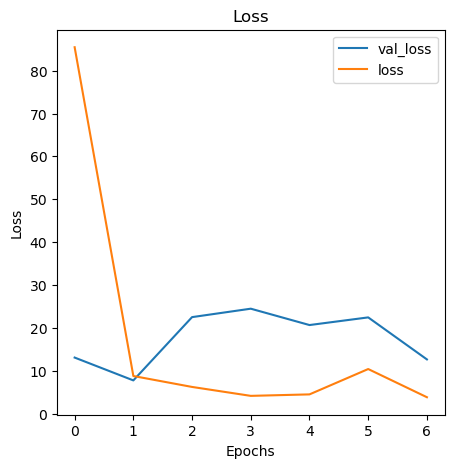

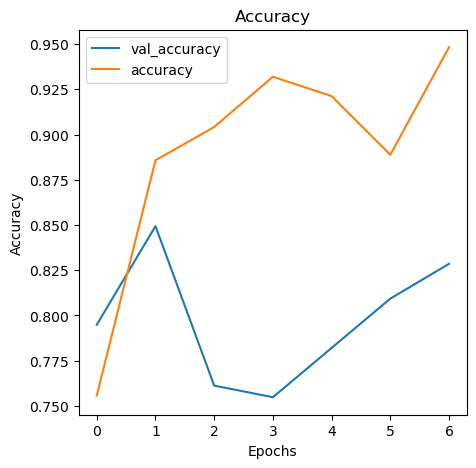

In [189]:
visualize_training_results(results2)

In [190]:
best_model = load_model('best_model.h5')

# Evaluate the best model on the testing set
test_loss, test_accuracy = best_model.evaluate(test_img_unrow, test_labels_final)

print("Testing Loss:", test_loss)
print("Testing Accuracy:", test_accuracy)

 5/20 [======>.......................] - ETA: 0s - loss: 9.8655 - accuracy: 0.8500 

2023-06-27 13:43:39.528966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 0s 11ms/step - loss: 10.3207 - accuracy: 0.8542
Testing Loss: 10.320719718933105
Testing Accuracy: 0.8541666865348816


We can see a large improvement from our previous model, as we now have achieved an accuracy on the test set of 85.4%. At the same time our loss has increased, and there is still overfitting, let's try to improve those numbers

### Dropout model
We will use dropout to try to improve the issue of overfitting.

In [223]:
tf.random.set_seed(42)
# Create the model
dropout_model = Sequential()

#add Input layer, with 64 hidden units and activation of relu
dropout_model.add(Dense(2048, activation='relu', input_shape=(12288,)))  
#add 20% dropout rate on the training set on input layer
dropout_model.add(Dropout(0.2))

#hidden layer with 32 units and relu activation
dropout_model.add(Dense(1024, activation='relu'))   
#add 20% dropout rate on the first hidden layer
dropout_model.add(Dropout(0.2))

# Output layer with 2 units for binary classification
dropout_model.add(Dense(1, activation='sigmoid'))

# Compile the model using adam
dropout_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
dropout_model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_92 (Dense)            (None, 2048)              25167872  
                                                                 
 dropout_36 (Dropout)        (None, 2048)              0         
                                                                 
 dense_93 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_37 (Dropout)        (None, 1024)              0         
                                                                 
 dense_94 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 27,267,073
Trainable params: 27,267,073
Non-trainable params: 0
_________________________________________________________________


In [224]:
tf.random.set_seed(42)
# Fit the model to the training data, run 20 epochs and use a batch size of 64
dropout_results = dropout_model.fit(train_img_unrow, train_labels_final, epochs=20, batch_size=64,
                      callbacks=early_stopping, validation_data=(test_img_unrow, test_labels_final))

Epoch 1/20


2023-06-27 13:55:31.300583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - ETA: 0s - loss: 323.5074 - accuracy: 0.7423

2023-06-27 13:55:33.845430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


82/82 [==============================] - 3s 31ms/step - loss: 323.5074 - accuracy: 0.7423 - val_loss: 12.3969 - val_accuracy: 0.7420
Epoch 2/20
82/82 [==============================] - 2s 22ms/step - loss: 6.5546 - accuracy: 0.8591 - val_loss: 4.5174 - val_accuracy: 0.8269
Epoch 3/20
82/82 [==============================] - 2s 21ms/step - loss: 3.0079 - accuracy: 0.8972 - val_loss: 3.6228 - val_accuracy: 0.8381
Epoch 4/20
82/82 [==============================] - 2s 21ms/step - loss: 2.4729 - accuracy: 0.9066 - val_loss: 11.8913 - val_accuracy: 0.6987
Epoch 5/20
82/82 [==============================] - 2s 21ms/step - loss: 2.5912 - accuracy: 0.9020 - val_loss: 2.5086 - val_accuracy: 0.8269
Epoch 6/20
82/82 [==============================] - 2s 22ms/step - loss: 1.3108 - accuracy: 0.9220 - val_loss: 5.5487 - val_accuracy: 0.7324
Epoch 7/20
82/82 [==============================] - 2s 22ms/step - loss: 1.8367 - accuracy: 0.9086 - val_loss: 23.6351 - val_accuracy: 0.6378
Epoch 8/20
82/82 [=

In [201]:
best_model = load_model('best_model.h5')

# Evaluate the best model on the testing set
test_loss, test_accuracy = best_model.evaluate(test_img_unrow, test_labels_final)

print("Testing Loss:", test_loss)
print("Testing Accuracy:", test_accuracy)

 5/20 [======>.......................] - ETA: 0s - loss: 9.8655 - accuracy: 0.8500 

2023-06-27 13:48:09.293040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 0s 12ms/step - loss: 10.3207 - accuracy: 0.8542
Testing Loss: 10.320719718933105
Testing Accuracy: 0.8541666865348816


This model seems to have been slightly better as one of our epochs has a accuracy on the validation set of 85.4%

### L2 model

In [ ]:
# Create the baseline model
L2_model = Sequential()

#add Input layer, with 64 hidden units and activation of relu
L2_model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(.005), 
                   input_shape=(12288,)))  

#hidden layer with 32 units and relu activation
L2_model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(.005)))   


# Output layer with 2 units for binary classification
L2_model.add(Dense(1, activation='sigmoid'))

# Compile the model using adam
L2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
L2_model.summary()

In [ ]:
# Fit the model to the training data, run 25 epochs and use a batch size of 64
L2_results = L2_model.fit(train_img_unrow, train_labels_final, epochs=25, batch_size=64,
                       validation_data=(test_img_unrow, test_labels_final))

Again, it's unclear if this model was better than our second model, because although the training values increased, the testing set values fluctuated a lot, between the high 60s and low 80s. Additionally, a similar affect occurs when tested with L1 regularizer

In [ ]:
# Create the baseline model
he_model = Sequential()

#add Input layer, with 64 hidden units and activation of relu
he_model.add(Dense(4096, activation='relu', kernel_initializer='he_normal', 
                   input_shape=(12288,)))  

#hidden layer with 32 units and relu activation
he_model.add(Dense(2048, activation='relu'))   

#hidden layer with 32 units and relu activation
he_model.add(Dense(1024, activation='relu')) 

# Output layer with 2 units for binary classification
he_model.add(Dense(1, activation='sigmoid'))

# Compile the model using adam
he_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
he_model.summary()

In [ ]:
# Fit the model to the training data, run 25 epochs and use a batch size of 64
he_results = he_model.fit(train_img_unrow, train_labels_final, epochs=50, batch_size=64, 
                          callbacks=early_stopping,
                       validation_data=(test_img_unrow, test_labels_final))

Again, we are not getting any better accuracy on our test set. Additionally, I tried the same thing with Lecun Initializer and the same thing occured

### CNN

In [ ]:
#lets pull up the shape of the data again
print('Train Images:', np.shape(train_images))
print('Train Labels:',np.shape(train_labels))
print('Test Images:',np.shape(test_images))
print('Test Labels:',np.shape(test_labels))
print('Val Images:',np.shape(val_images))
print('Val Labels:',np.shape(val_labels))

In [ ]:
#Normalize pixel values to between 0 and 1
train_images, test_images, val_images = train_images/255, test_images/255, val_images/255

In [ ]:
conv_model = Sequential()

In [ ]:
conv_model.add(Conv2D (256, (3, 3), activation='tanh', input_shape= (64, 64, 3))) 
conv_model.add(MaxPooling2D( (2, 2))) 
conv_model.add(Conv2D(512, (3, 3), activation='tanh')) 
conv_model.add(MaxPooling2D( (2, 2))) 
conv_model.add(Conv2D(1024, (3, 3), activation='tanh'))

In [ ]:
conv_model.summary()

In [ ]:
conv_model.add(Flatten())
conv_model.add(Dense(64, activation='tanh' )) 
conv_model.add(Dense(1, activation='sigmoid'))

In [ ]:
conv_model.summary()

In [ ]:
conv_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
conv_model.fit(train_images, train_labels_final, epochs=10, batch_size=1000, 
               callbacks=early stop)

In [ ]:
test_loss, test_acc = model.evaluate (test_images, test_labels)